In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

from pathlib import Path
from matLoader import loadMat
from imageComp import npImage, weighted_average_images, boost_contrast

In [2]:
f = r"C:\Users\augus\NIN_Stuff\data\koenData\Koen_to_Augustijn\Ajax_20241012_001_normcorr_SPSIG_Res.mat"
fdata = loadMat(f)

Using custom loadMat to load matlab file into a dictionary object

In [3]:
def plotAvgSig(data, idx:int=0, imageFolder:str=r"C:\Users\augus\NIN_Stuff\data\koenData\Koen_to_Augustijn\ajaxNeuronAvg"):
    def plotForOne(signal, name, filepath):
        mean = np.mean(signal, axis=1)
        std = np.std(signal, axis=1)

        x = np.arange(24)

        plt.errorbar(x, mean, yerr=std, fmt='-o', capsize=5)
        #plt.xlabel('Time point')
        #plt.ylabel('Average value')
        plt.title(name)
        plt.savefig(filepath)
        plt.close()

    curDir = Path(os.path.join(imageFolder,str(idx)))
    curDir.mkdir(exist_ok=True)

    signals = ["CaSig", "CaSigRaw", "CaSigCorrected", "CaDen", "CaDenCorrected", "CaDec", "CaDeconCorrected","CaSpike_prob"]
    for signal in signals:
        filepath = os.path.join(curDir, signal)
        curSig = data.Res[signal][:,:,idx]
        plotForOne(curSig, signal, filepath)

    return


for i in range(0,10):
    plotAvgSig(fdata, i)

plotting average traces with errors bars. Initially seen that CaDec and CaDeconCorrected seem to have the clearest trace. This could be full of errors and a much more thorough check should be run in order to ensure there is no loss in information/data etc... 

Need to get the full non trial locked data for a more thorough analysis

In [60]:
def normaliseNeuron(arr:np.ndarray, idx:int):
    #assume format is #trials , neurons

    curArr = arr[:, idx]

    min_val = np.min(curArr)
    max_val = np.max(curArr)

    normalized_array = (curArr - min_val) / (max_val - min_val)
    return normalized_array

In [ ]:
Sig = fdata.Res.CaDec
SigCor = fdata.Res.CaDeconCorrected
imgID = fdata.info.Stim.Log
baseIMGPath = Path(r"C:\Users\augus\NIN_Stuff\data\koenData\Koen_to_Augustijn\4000imgNPY")
x = np.arange(4000)

def getPaths(basePath:str, log:np.ndarray, extension:str=".npy"):
    if log.ndim != 1:
        raise ValueError("expect one dimensional path")
    length = log.shape[0]

    paths = [0]*length
    for i in range(length):
        end = f"{int(log[i]):04d}{extension}"
        origPath = os.path.join(basePath, end)
        corPath = npImage._checkPath(origPath, extension)
        paths[i] = corPath
    return paths

imgIDPaths = getPaths(baseIMGPath, imgID)
for path in imgIDPaths:
    assert os.path.isfile(path)

In [67]:
AvgSig = Sig.sum(axis=0)
AvgSigCor = SigCor.sum(axis=0)
neuronID = 0

CHOOSE ABOVE KEY VARS

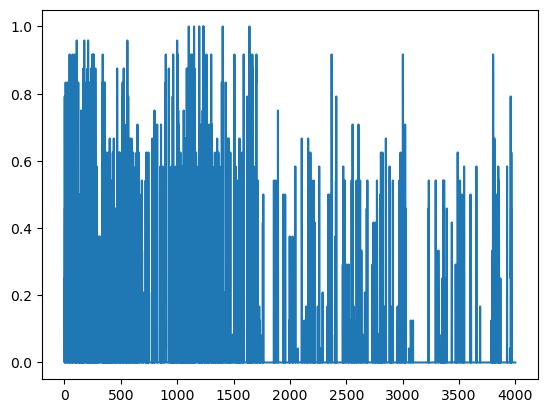

In [68]:
normalised = normaliseNeuron(AvgSig, neuronID)

plt.plot(x, normalised)
plt.show()

In [ ]:
receptiveField = weighted_average_images(imgIDPaths, normalised)
BoostedReceptiveField = boost_contrast(receptiveField)
res = Path(r"C:\Users\augus\NIN_Stuff\data\koenData\Koen_to_Augustijn\4000imgResults")

mouseName = "Ajax"

savePath = os.path.join(res, f"receptiveField{mouseName}{neuronID}")
BoostedSavePath = os.path.join(res, f"BoostedReceptiveField{mouseName}{neuronID}")
np.save(os.path.join(savePath, "_numpy"), receptiveField)
npy_to_png(matrix=receptiveField, png_path=savePath)
npy_to_png(matrix=BoostedReceptiveField, png_path=BoostedSavePath)


iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
iteration: 72
i

In [ ]:
from imageComp import png_to_npy

rawImg = r"C:\Users\augus\NIN_Stuff\data\koenData\Koen_to_Augustijn\4000imgResults\BoostedReceptiveFieldAjax0.png"

